### Notebook to illustrate MCMC sampling of Norms from pre-defined PCFGs

 *There are  the 5 main sections :*  
 **1. Initialising Environment and True Expression**  
 **2. Create Action Data on environment while performing randomised tasks**  
 **3. Run MCMC Algorithms to learn expressions from the data created earlier**  
 **4. Test  the performance of MCMC Algorithm by calculating Preciscion and Recall of Learned Norms**  
 **5. Test the convergence of MCMC algorithm**  

In [1]:
#Import the different modules required
from environment import *
from rules_4 import *
from robot_task_new import *
from algorithm_1_v4 import create_data,algorithm_1,to_tuple
from mcmc_performance import performance
from mcmc_convergence import prepare_sequences,calculate_R

import matplotlib.pyplot as plt
from collections import Counter
import pickle
import time
import seaborn as sns
import os
import sys
from tqdm import tnrange, tqdm_notebook


### 1. Initialising Environment and True Expression
* *Environment can be initialisaed with any number of objects (default=20) and a seed value can also be fed.*
* *Expression refers to Norms initialised from the PCFG, True Expression means the eexpression used to create data which if further used to learn norms from MCMC.*


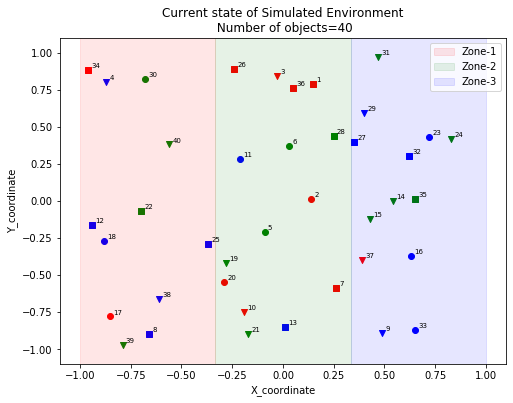

In [2]:
env=create_env(N=40)
fig,ax=plt.subplots(figsize=(8,6))
plot_env(env,ax,legend=True)

#Dump env to file
with open('./demo/demo_env.sv', 'wb') as fp:
    pickle.dump(env, fp)

In [4]:
true_expression=expand("NORMS")
print_expression(true_expression)

# Testing functions from verify_action_4
from verify_action_4 import *
from rules_4 import *
the_per = true_expression[2]

#Dump expression
with open('./demo/demo_exp.sv', 'wb') as fp:
    pickle.dump(true_expression, fp)

------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITION: action pickup
     for colour r, shape triangle and zone 2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMISSION: action pickup
     for colour g, shape circle and zone any


### 2. Create Action Data on environment while performing randomised tasks
Action data is can be created in two ways (parametrised by random_task):
1. Either Initialising a task beforehand and performing it ceratin times (*num_repeat*)
2. or, by initialisng random tasks for each iteration in *num_repeat*. In such a case relevance of tasks becomes redundant, and though target are of task is randomised, scope of task (i.e. color and shape of objects) is fixed. And in next step rf must be passed as nan.

In both the cases the repetition of tasks is on the original state of environment provided to function

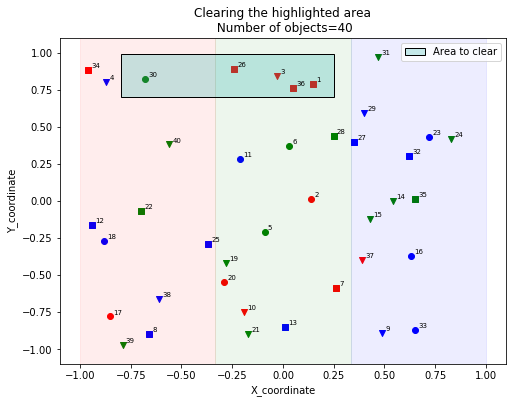

In [5]:
target_area=[position(-0.8,0.7),position(0.25,0.99)]
task1=task(colour_specific=np.nan,shape_specific=np.nan,target_area=target_area)
fig,ax=plt.subplots(figsize=(8,6))
plot_task(env,ax,"Clearing the highlighted area",task1,True)
#fig.savefig("example_task.pdf", bbox_inches='tight')

In [6]:
from importlib import reload
from rules_4 import *
from verify_action_4 import *
from copy import deepcopy


rules = [true_expression[1], true_expression[2]]
rob = robot(task1,deepcopy(env))
actionable = rob.all_actionable()
print(actionable)
print()

if true_expression[1][0]=="Pro":
    the_pro = true_expression[1]
    print("Prohibition match check for", the_pro)
    for oid in actionable:
        env[0][oid].describe()
        print(check_pro_or_per(env[0][oid],pro_or_per_action(the_pro),{1:the_pro}))
        print()

if true_expression[1][0]=="Obl":
    rule = true_expression[1]
    print("Obligation match check for", rule)
    cond = rule[1]
    conds_list = separate_conds(cond)
    next_move = conds_list[-1]
    for oid in actionable:
        env[0][oid].describe()
        print(check_obl(env[0][oid],{1:rule}))
        print()
    
the_per = true_expression[2]
print("Permission match check for", the_per)
for oid in actionable:
    env[0][oid].describe()
    print(check_pro_or_per(env[0][oid],pro_or_per_action(the_per),{1:the_per}))
    print()

rob = robot(task1,deepcopy(env))
rob.all_compliant(rules,"foo")


[1, 3, 26, 30, 36]

Prohibition match check for['Pro', ['Action', 'pickup'], ['Colour', 'r'], ['Shape', 'triangle'], ['Zone', '2']]
Object 2: color=r,shape=circle,current_zone=2,last_action=nan
(0, nan, nan)

Object 4: color=b,shape=triangle,current_zone=1,last_action=nan
(0, nan, nan)

Object 27: color=b,shape=square,current_zone=3,last_action=nan
(0, nan, nan)

Object 31: color=g,shape=triangle,current_zone=3,last_action=nan


In [20]:
env[0][8].describe()


color=b,shape=triangle,current_zone=Zone-3,last_action=nan


In [40]:
s=time.time()
action_profile_with_norms=create_data(true_expression,env,name="demo",task1=task1,random_task=False,
                num_actionable=np.nan,num_repeat=250,verbose=False)
print ("Time Taken to complete job={:.2f}s\n".format(time.time()-s))

Generating action-profile data for case demo



Time Taken to complete job=129.84s



In [41]:
data=[]
for itr,ap in action_profile_with_norms.items():
    for i in range(0,int(len(ap)/2)):
        data.append(tuple([ap[2*i],ap[2*i+1]]))
print ("Data Generated:")
for i in range(5):
    print(data[i])
    
with open('./demo/demo_data.sv', 'wb') as fp:
    pickle.dump(data, fp)

Data Generated:
(('pickup', 17), ('putdown', 17, 1))
(('pickup', 27), ('putdown', 27, 3))
(('pickup', 37), ('putdown', 37, 1))
(('pickup', 29), ('putdown', 29, 1))
(('pickup', 2), ('putdown', 2, 3))


### 3. Run MCMC Algorithm to learn expressions from the data created earlier
1. rf is the relevance discounting factor for irrelevant expressions.
2. sim_t is the similarity threshold: cos(E1,E2) above which p_accept is penalised.
3. sim_pen is the penalty imposed if the above threshold is crossed.

In [42]:
# Different parameters for MCMC sequence
rf=0.5 #To negate relevance logic use np.nan
sim_t=0.8
sim_pen=0.7 #To negate similarity logic use 1

In [43]:
s=time.time()
print ("Generating sequence")
exp_seq,lik_list=algorithm_1(data,env,task1,true_expression,q_dict,rule_dict,
                                       filename="demo/demo_mcmc_report",
                                       sim_threshold=sim_t,similarity_penalty=sim_pen,
                                       relevance_factor=rf,max_iterations=50000,verbose=False)
print ("\nTime Taken to complete job={:.2f}s\n".format(time.time()-s))

Generating sequence
Time to initialise E_0=0.0590s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     B-CIRCLEs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PICKUP
     B-SQUAREs in ZONE-2




Time Taken to complete job=639.41s



In [44]:
learned_expressions=Counter(map(to_tuple,exp_seq[int(len(exp_seq)/2)+1:]))#Discarding 1 half as warmup
print ("Number of unique Norms in sequence={}".format(len(learned_expressions)))

Number of unique Norms in sequence=54


In [45]:
# Write top norms to file
filename="demo_top_norms"
top=learned_expressions.most_common()
t=sum(learned_expressions.values())
exists = os.path.isfile('./demo/{}.txt'.format(filename))
if exists==True:
    os.remove('./demo/{}.txt'.format(filename))
original = sys.stdout
for i in range(len(top)):
    exp=top[i]
    if (i%10==0):
        print("Rank:{} Norm has relative frequency={:.3f}%".format(i+1,exp[1]*100/t))
    sys.stdout = open('./demo/{}.txt'.format(filename), 'a+')
    print("\n\n\n************Rank:{}, %-Frequency={:.3f}%**********".format(i+1,exp[1]*100/t))
    print_expression(exp[0])
    print("*************************************************")
    sys.stdout=original

Rank:1 Norm has relative frequency=13.968%
Rank:11 Norm has relative frequency=1.848%
Rank:21 Norm has relative frequency=1.708%
Rank:31 Norm has relative frequency=1.616%
Rank:41 Norm has relative frequency=1.464%
Rank:51 Norm has relative frequency=1.284%


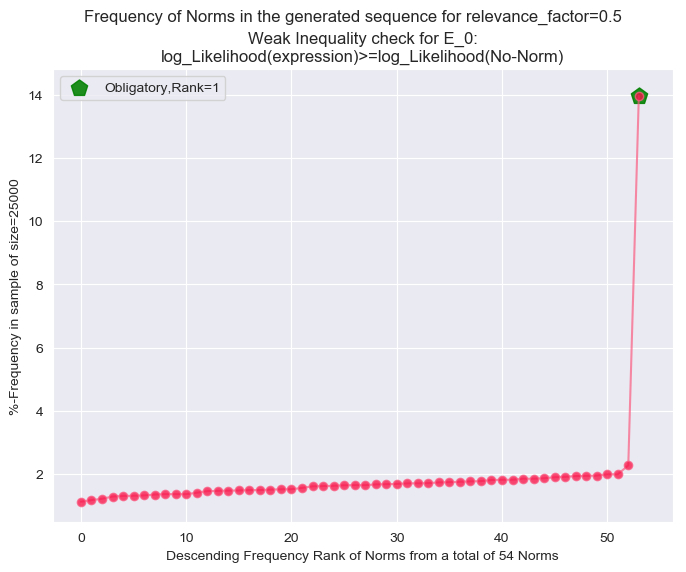

In [46]:
# Visualise the frequency of top plots
sns.set_style("darkgrid")
fig,ax=plt.subplots(figsize=(8,6),dpi=100)
fig.suptitle('Frequency of Norms in the generated sequence for relevance_factor={}'.format(rf))

t_l=sum(learned_expressions.values())
ax.plot([x*100/t for x in sorted(learned_expressions.values())],"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax.set_ylabel("%-Frequency in sample of size={}".format(t))
ax.set_xlabel("Descending Frequency Rank of Norms from a total of {} Norms".format(len(learned_expressions)))
ax.title.set_text("Weak Inequality check for E_0:\nlog_Likelihood(expression)>=log_Likelihood(No-Norm)")
obl_rank=[] #Ascending order Rank
for rank,x in enumerate(learned_expressions.most_common(),1):
    if x[0][1][0] =="Obl":
        obl_rank.append(rank)
for rank in obl_rank:
    ax.scatter(x=len(learned_expressions)-rank,
               y=sorted(learned_expressions.values())[len(learned_expressions)-rank]*100/t,
               c='green',s=151,marker='p',alpha=0.88,label='Obligatory,Rank={}'.format(rank))
ax.legend();

### 4. Calculate Preciscion and Recall for the Learned Norms

  * #####  Precision = $\frac{|\ true-data\ ∩\ predicted-data\ |}{|\ true-data\ |}$
  * #####  Recall = $\frac{|\ true-data\ ∩\ predicted-data\ |}{|\ predicted-data\ |}$
  * #####  F_beta = $\frac{(1+\beta^2)\  . \ (precision\ *\ recall)}{(\beta^2.precision\ +\ recall)}$
   where,
   *           True Data = All Possible Action Profiles that can be produced by true/trace expression
   *           Predicted Data = All Possible Action Profiles that can be produced by learned expression

In [47]:
# Calculate precision and recall of top_n norms from learned expressions
pr_result=performance(task1,env,true_expression,learned_expressions,
                      folder_name="demo",file_name="top_norm",
                      top_n=np.nan,beta=1,verbose=False)
pr_result.head()

,norm_rank,weight,precision,recall,F_1
0,1,0.13968,1.0,1.0,1.0
1,2,0.02272,1.0,1.0,1.0
2,3,0.01988,1.0,1.0,1.0
3,4,0.01988,1.0,1.0,1.0
4,5,0.01948,1.0,1.0,1.0


### 5. Test the convergence of MCMC Chain

<img src="mcmc_convergence/B_W_def.jpeg" alt="Drawing" style="width: 700px;float: center"/> 

In [48]:
n=10000 #Length of sequence after discarding warm-up part and splitting in half
m=10 #Number of sequences after splitting in half

sequence_list=[]
for i in tnrange(1,int(m/2+1),desc="Loop for Individual Chains"):
    print ("\n:::::::::::::::::::: FOR SEQUENCE {} ::::::::::::::::::::".format(i))
    exp_seq,lik_list=algorithm_1(data,env,task1,true_expression,q_dict,rule_dict,
                                       filename="demo/convergence/report_for_chain_{}".format(i),
                                       sim_threshold=sim_t,similarity_penalty=sim_pen,
                                       relevance_factor=rf,max_iterations=4*n,verbose=False)
    sequence_list.append(exp_seq)


:::::::::::::::::::: FOR SEQUENCE 1 ::::::::::::::::::::
Time to initialise E_0=0.0300s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     B-CIRCLEs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PICKUP
     G-CIRCLEs in ZONE-3



:::::::::::::::::::: FOR SEQUENCE 2 ::::::::::::::::::::
Time to initialise E_0=0.6180s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     B-CIRCLEs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PICKUP
     R-TRIANGLEs in ZONE-2



:::::::::::::::::::: FOR SEQUENCE 3 ::::::::::::::::::::
Time to initialise E_0=0.6210s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     B-CIRCLEs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     R-TRIANGLEs in ZONE-2



:::::::::::::::::::: FOR SEQUENCE 4 ::::::::::::::::::::
Time to initialise E_0=0.0800s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > OBLIGATORY to
     PUTDOWN B-CIRCLEs in ZONE-1
     if you PICKUP B-CIRCLEs
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     B-CIRCLEs in ZONE-3



:::::::::::::::::::: FOR SEQUENCE 5 ::::::::::::::::::::
Time to initialise E_0=0.3570s
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     B-CIRCLEs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     R-TRIANGLEs in ZONE-1


In [49]:
convergence_result=calculate_R(prepare_sequences(sequence_list,warmup=True),50)
convergence_result


Calculating Variance for 1st 50 iterations
Time taken for job=0.4s

Calculating Variance for 1st 100 iterations
Time taken for job=0.7s

Calculating Variance for 1st 200 iterations
Time taken for job=1.5s

Calculating Variance for 1st 400 iterations
Time taken for job=3.1s

Calculating Variance for 1st 800 iterations
Time taken for job=6.3s

Calculating Variance for 1st 1600 iterations
Time taken for job=13.4s

Calculating Variance for 1st 3200 iterations
Time taken for job=25.8s

Calculating Variance for 1st 6400 iterations
Time taken for job=55.2s

Calculating Variance for 1st 10000 iterations
Time taken for job=91.1s



,iterations,R,within_seq_var,between_seq_var,var_over_est
0,50,1.000314,5.469551,39.863111,5.472990
1,100,1.000313,5.820768,42.288222,5.824414
2,200,1.000311,5.993834,43.227222,5.997558
3,400,1.000347,6.075675,48.304000,6.079898
4,800,1.000343,6.123026,48.110389,6.127224
5,1600,1.002246,6.356199,292.204208,6.384784
6,3200,1.005616,6.440944,731.894535,6.513490
7,6400,1.008423,6.745303,1147.812757,6.859409
8,10000,1.007436,6.618031,994.498911,6.716819
